# 챔피언 군집화

이번 강의에선 각 챔피언을 군집화하여 특정 챔피언을 선호하는 사람에게 다른 챔피언을 추천할 수 있게 분석을 하였다.

챔피언 군집화 기준으론 챔피언별 구입한로 아이템을 사용한다.

정확하게 이번 강의는 출력할 형태를 알려주고 직접 코드를 작성하는 방식으로 7,8일차 동안 진행하였다.

In [1]:
# 패키지 로드
import os
import numpy as np
import pandas as pd
# import pymysql
import requests
import math
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
# 라이엇 개발자 페이지에서 게임 상수 최신 버전 정보 가져오기
constant_patch = requests.get("https://ddragon.leagueoflegends.com/api/versions.json").json()[0]

# constant_patch == '11.16.1'

# 라이엇 개발자 페이지에서 최신 버전 한국 서버 아이템 정보 가져오기
item_info = requests.get(f"http://ddragon.leagueoflegends.com/cdn/{constant_patch}/data/ko_KR/item.json").json()

# 라이엇 개발자 페이지에서 최신 버전 한국 서버 챔피언 정보 가져오기
champion_info = requests.get(f"http://ddragon.leagueoflegends.com/cdn/{constant_patch}/data/ko_KR/champion.json").json()

# item_info, champion_info는 json형태

- 항상 최신 버전을 불러오기 위해 버전 정보를 변수로 사용하여 아이템, 챔피언 정보를 불러왔다.

In [3]:
# 챔피언 정보 => DataFrame으로 변환
champion_df = pd.DataFrame(champion_info['data']).T[['key','name']]
champion_df = champion_df.reset_index(drop=True)
# champion_df는 'key'로 id값, 'name'으로 챔피언 한국어 이름을 가지는 156rows짜리 DataFrame

# champion_df의 'key' column string => numeric 변환
champion_df['key'] = pd.to_numeric(champion_df['key'])

## 1. 아이템 가격 데이터

우선 각 아이템의 가격 데이터를 만들 것이다.

아이템은 하위템이 존재하고 여기서 작업하는 바는 특정 템의 하위템과 조합비용 등을 출력하는 것이다.

자세한 것은 조금 후에 알 수 있다.

### 1.1 방법1 (보완필요)

우선 이 방법은 처음 가이드라인으로 준 방식이 아닌 완전 새롭게 해보려고 직접 작성한 코드이다.

뒤의 결과로 나타나지만 약간의 보완은 필요하지만 괜찮은 방법인 것 같다.

방법2가 가이드라인이고 자세한 설명이 적혀있다.

In [4]:
# consumed가 null인 경우만
item = pd.DataFrame(item_info['data']).T[['name','gold','tags','from','consumed']]
item2 = item[item["consumed"].isnull()].drop(columns="consumed", axis=1)
item2

,name,gold,tags,from
1001,장화,"{'base': 300, 'purchasable': True, 'total': 30...",[Boots],NaN
1004,요정의 부적,"{'base': 250, 'purchasable': True, 'total': 25...",[ManaRegen],NaN
1006,원기 회복의 구슬,"{'base': 150, 'purchasable': True, 'total': 15...",[HealthRegen],NaN
1011,거인의 허리띠,"{'base': 500, 'purchasable': True, 'total': 90...",[Health],[1028]
1018,민첩성의 망토,"{'base': 600, 'purchasable': True, 'total': 60...",[CriticalStrike],NaN
...,...,...,...,...
6692,월식,"{'base': 850, 'purchasable': True, 'total': 32...","[Damage, LifeSteal, SpellVamp, NonbootsMovemen...","[3134, 1036, 1053]"
6693,자객의 발톱,"{'base': 1000, 'purchasable': True, 'total': 3...","[Damage, Active, CooldownReduction, NonbootsMo...","[3134, 3133]"
6694,세릴다의 원한,"{'base': 650, 'purchasable': True, 'total': 32...","[Damage, CooldownReduction, ArmorPenetration, ...","[3133, 3035]"
6695,독사의 송곳니,"{'base': 625, 'purchasable': True, 'total': 26...","[Damage, ArmorPenetration]","[3134, 1037]"


- 우선 json 파일에 consumed라는 키가 존재하면 제거하였다(소모품).


- `pd.json_normalize()`를 사용하지 않았고 여기서 gold, tags, from 컬럼의 값은 문자가 아닌 dictionary, list이다.


- gold에서 base는 조합비용, total은 전체 구입비용이다.


- 자세한 것은 본인이 직접 뜯어보고 이해하여야 한다.

In [5]:
# tags에 Consumable이 있으면 제외
item3 = item2[item2["tags"].apply(lambda x: False if "Consumable" in x else True)]
item3

,name,gold,tags,from
1001,장화,"{'base': 300, 'purchasable': True, 'total': 30...",[Boots],NaN
1004,요정의 부적,"{'base': 250, 'purchasable': True, 'total': 25...",[ManaRegen],NaN
1006,원기 회복의 구슬,"{'base': 150, 'purchasable': True, 'total': 15...",[HealthRegen],NaN
1011,거인의 허리띠,"{'base': 500, 'purchasable': True, 'total': 90...",[Health],[1028]
1018,민첩성의 망토,"{'base': 600, 'purchasable': True, 'total': 60...",[CriticalStrike],NaN
...,...,...,...,...
6692,월식,"{'base': 850, 'purchasable': True, 'total': 32...","[Damage, LifeSteal, SpellVamp, NonbootsMovemen...","[3134, 1036, 1053]"
6693,자객의 발톱,"{'base': 1000, 'purchasable': True, 'total': 3...","[Damage, Active, CooldownReduction, NonbootsMo...","[3134, 3133]"
6694,세릴다의 원한,"{'base': 650, 'purchasable': True, 'total': 32...","[Damage, CooldownReduction, ArmorPenetration, ...","[3133, 3035]"
6695,독사의 송곳니,"{'base': 625, 'purchasable': True, 'total': 26...","[Damage, ArmorPenetration]","[3134, 1037]"


- tags는 아이템에 대한 태그 설명으로 Consumable이 존재하면 삭제하여 4건을 더 지웠다.

In [6]:
# item_df 완성
item_df = item3.copy()
item_df["base_gold"] = item3["gold"].apply(lambda x: x['base'])
item_df["total_gold"] = item3["gold"].apply(lambda x: x['total'])

item_df.drop(columns=["gold","tags"], inplace=True)
item_df

,name,from,base_gold,total_gold
1001,장화,NaN,300,300
1004,요정의 부적,NaN,250,250
1006,원기 회복의 구슬,NaN,150,150
1011,거인의 허리띠,[1028],500,900
1018,민첩성의 망토,NaN,600,600
...,...,...,...,...
6692,월식,"[3134, 1036, 1053]",850,3200
6693,자객의 발톱,"[3134, 3133]",1000,3200
6694,세릴다의 원한,"[3133, 3035]",650,3200
6695,독사의 송곳니,"[3134, 1037]",625,2600


- 각 아이템의 기본 정보 item_df를 만들었다.

In [7]:
# item_tree 완성
item_tree = pd.DataFrame(item_df["from"].apply(lambda x: pd.Series(x)).stack()).reset_index(level=1, drop=True)
item_tree = item_tree.reset_index()
item_tree.rename(columns={"index":"id", 0:"id_from"}, inplace=True)
item_tree

,id,id_from
0,1011,1028
1,1031,1029
2,1043,1042
3,1043,1042
4,1053,1036
...,...,...
295,6694,3035
296,6695,3134
297,6695,1037
298,8001,3067


- item_tree는 각 아이템의 하위 템을 id_from으로 가지는 데이터 프레임이다.


- stack된 형태로 생성하였으며 하위 템이 없는 아이템은 id에 포함되지 않는다.

In [8]:
# index 컬럼으로 바꿔주기
item_df = item_df.reset_index()
item_df.rename(columns={'index':"id"}, inplace=True)
item_df

,id,name,from,base_gold,total_gold
0,1001,장화,NaN,300,300
1,1004,요정의 부적,NaN,250,250
2,1006,원기 회복의 구슬,NaN,150,150
3,1011,거인의 허리띠,[1028],500,900
4,1018,민첩성의 망토,NaN,600,600
...,...,...,...,...,...
179,6692,월식,"[3134, 1036, 1053]",850,3200
180,6693,자객의 발톱,"[3134, 3133]",1000,3200
181,6694,세릴다의 원한,"[3133, 3035]",650,3200
182,6695,독사의 송곳니,"[3134, 1037]",625,2600


- 아이템 id를 컬럼으로 바꿔주었다.

In [9]:
#item_df[item_df["id"]=="4643"]

In [10]:
# left join으로 하위템에 아이템을 붙혔을 때 하위템이 있는 경우만 남기기
# 즉, 추가한 id_from이 NaN이 아닌 경우
item_tree_full = item_tree
item_tree_new = item_tree

# 하위템에 하위템이 있는 경우를 고려해서 while문으로 작성
while True:
    temp = pd.merge(item_tree_new, item_tree_full, left_on="id_from", right_on="id", how="left")
    temp2 = temp[["id_x","id_from_y"]]

    if temp2["id_from_y"].notnull().sum() == 0:
        break

    item_tree_new = temp2[temp2["id_from_y"].notnull()]
    item_tree_new.rename(columns={"id_x":"id","id_from_y":"id_from"}, inplace=True)

# 기존 item_tree에 row를 추가
item_tree_full = pd.concat([item_tree_full, item_tree_new], axis=0)
item_tree_full

C:\Users\ekzm3\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,id,id_from
0,1011,1028
1,1031,1029
2,1043,1042
3,1043,1042
4,1053,1036
...,...,...
369,6694,1036
370,6695,1036
371,6695,1036
373,8001,1028


- 위 과정은 item_tree에서 하위템의 하위템이 존재하니 이를 merge를 통해 최종 하위템을 붙혀준다.


- while을 사용한 이유는 하위템의 하위템의 하위템... 등 때문이나 여기선 한번만 작동한다.


- 현재 라이엇 아이템은 최종 - 하위 - 하위 구조로 이루어져 있기 때문이다.


- 기존 300개의 item_tree에서 207개의 row가 추가되었다.

In [11]:
# 자기 자신 추가해주기
id_self = pd.DataFrame([item_tree_full["id"].unique(), item_tree_full["id"].unique()]).T
id_self.columns = item_tree_full.columns
item_tree_full = pd.concat([item_tree_full, id_self], axis=0)
item_tree_full = item_tree_full.sort_values(by="id")
item_tree_full

,id,id_from
0,1011,1028
0,1011,1011
1,1031,1029
1,1031,1031
2,1043,1042
...,...,...
373,8001,1028
374,8001,1028
299,8001,1011
298,8001,3067


- 자기 자신을 추가하였다.


- 예를 들면 유령무희 - 유령무희를 추가해두었다.


- 이런 형태를 만든 이유는 조합비용 컬럼을 사용하기 위함이다.

In [12]:
# 아이템별 골드 추가해주기
#pd.merge(item_tree_full)
item_tree_full2 = pd.merge(item_tree_full, item_df, left_on="id_from", right_on="id")
item_tree_full2

,id_x,id_from,id_y,name,from,base_gold,total_gold
0,1011,1028,1028,루비 수정,NaN,400,400
1,2065,1028,1028,루비 수정,NaN,400,400
2,3001,1028,1028,루비 수정,NaN,400,400
3,3044,1028,1028,루비 수정,NaN,400,400
4,3050,1028,1028,루비 수정,NaN,400,400
...,...,...,...,...,...,...,...
633,6692,6692,6692,월식,"[3134, 1036, 1053]",850,3200
634,6693,6693,6693,자객의 발톱,"[3134, 3133]",1000,3200
635,6694,6694,6694,세릴다의 원한,"[3133, 3035]",650,3200
636,6695,6695,6695,독사의 송곳니,"[3134, 1037]",625,2600


In [13]:
item_tree_full3 = item_tree_full2.groupby(["id_x", "id_from"]).sum().reset_index()
item_tree_full3 = item_tree_full3[["id_x","id_from","base_gold"]]
item_tree_full3.rename(columns={"id_x":"id"}, inplace=True)
#temp[temp["id"]=="3046"]
item_tree_full3

,id,id_from,base_gold
0,1011,1011,500
1,1011,1028,400
2,1031,1029,300
3,1031,1031,500
4,1043,1042,600
...,...,...,...
537,6695,6695,625
538,8001,1011,500
539,8001,1028,800
540,8001,3067,400


- 각 아이템, 하위템별로 골드 합계를 구하였다.


- 예를 들어 유령무희는 하위템으로 단검이 2개 필요하기에 이를 반영한 것이다.


- 여기서 id별로 합계를 구하면 해당 아이템의 전체 비용을 구할 수 있을 것이다.

### 1.2 방법2

In [14]:
# pd.json_normalize(item_info['data']['1011'], record_path=["tags"])

In [15]:
# 아이템 정보 => DataFrame으로 변환
item_df = pd.DataFrame(columns=['id','name','gold'])

# item_df는 아이템의 숫자 id, 한국어 이름(name) 및 조합비(직전 하위템 전부 갖고 있을 때 완성템을 조합할 때 드는 비용)를 가지는 DataFrame

item_tree = pd.DataFrame(columns=['id','id_from'])

# item_tree는 아이템의 숫자 id, 직전 하위템 리스트(id_from)를 가지는 DataFrame
# 예시: 유령 무희(2600G) = 롱소드(350G) + 열정의 검(1050G) + 롱소드(350G) + 850G이므로 유령 무희에 대한 rows가 3개 나옴

for item_id in item_info['data']:
    # Consumable한 아이템(체력 물약 등) 제외
    # 'tags'에 'Consumable' 정보가 없는 아이템에 대해서만 수행
    if item_info['data'][item_id]['tags'].count("Consumable") == 0:
        try:
            # 'consumed' 필드가 있는 아이템(비스킷)은 하단 코드가 실행되지 않고 continue로 바로 다음 item_id로 넘어감
            item_info['data'][item_id]['consumed']
            #작성#
            continue
        except:
            pass
        
        # 아이템명 및 조합비
        # id, name, gold 3개 필드를 가지게끔 json parsing
        name = item_info['data'][item_id]['name']
        base_gold = item_info['data'][item_id]['gold']["base"]
        
        item_row = pd.DataFrame([item_id, name, base_gold]).T
        item_row.columns = item_df.columns
        
        item_df = pd.concat([item_df,item_row])

        # 직전 하위템
        try:
            # 'from' 필드에 있는 항목을 각각 하나의 row로 가지는 item_row_tree DataFrame 생성
            item_row_tree = pd.DataFrame()
            item_row_tree["id_from"] = item_info['data'][item_id]['from']
            item_row_tree["id"] = item_id
            item_row_tree = item_row_tree[["id","id_from"]]
            # 작성
            ###
            item_tree = pd.concat([item_tree, item_row_tree])
        # 하위템이 없는 경우 생략
        except Exception:
            pass

- 이 부분은 가이드라인을 보고 내가 생각한대로 작성한 코드이다.

In [16]:
# 아이템 정보 => DataFrame으로 변환
item_df = pd.DataFrame(columns=['id','name','gold'])

# item_df는 아이템의 숫자 id, 한국어 이름(name) 및 조합비(직전 하위템 전부 갖고 있을 때 완성템을 조합할 때 드는 비용)를 가지는 DataFrame

item_tree = pd.DataFrame(columns=['id','id_from'])

# item_tree는 아이템의 숫자 id, 직전 하위템 리스트(id_from)를 가지는 DataFrame
# 예시: 유령 무희(2600G) = 롱소드(350G) + 열정의 검(1050G) + 롱소드(350G) + 850G이므로 유령 무희에 대한 rows가 3개 나옴

for item_id in item_info['data']:
    # Consumable한 아이템(체력 물약 등) 제외
    # 'tags'에 'Consumable' 정보가 없는 아이템에 대해서만 수행
    if "Consumable" not in pd.json_normalize(item_info['data'][item_id],record_path=['tags']).values:
        try:
            # 'consumed' 필드가 있는 아이템(비스킷)은 하단 코드가 실행되지 않고 continue로 바로 다음 item_id로 넘어감
            pd.json_normalize(item_info['data'][item_id]).consumed
            #작성#
            continue
        except:
            pass
        
        # 아이템명 및 조합비
        # id, name, gold 3개 필드를 가지게끔 json parsing
        item_row = pd.json_normalize(item_info['data'][item_id])[['name','gold.base']]
        item_row["id"] = item_id
        item_row.rename(columns={"gold.base":"gold"},inplace=True)
        
        
        item_df = pd.concat([item_df,item_row])

        # 직전 하위템
        try:
            # 'from' 필드에 있는 항목을 각각 하나의 row로 가지는 item_row_tree DataFrame 생성
            item_row_tree = pd.json_normalize(item_info['data'][item_id], record_path=["from"])
            item_row_tree.rename(columns={0:"id_from"},inplace=True)
            item_row_tree["id"] = item_id
            
            # 작성
            ###
            item_tree = pd.concat([item_tree, item_row_tree])
        # 하위템이 없는 경우 생략
        except Exception:
            pass

<ipython-input-16-1135ef07f429>:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "Consumable" not in pd.json_normalize(item_info['data'][item_id],record_path=['tags']).values:


- 이건 강사님께서 시간을 주신 후 설명해주신 방법대로 작성한 코드이다.


- `pd.json_normalize()`를 사용한 방식이 다르다.


- 강사님이 적어주신 주석을 통해 출력할 데이터 프레임 형태를 만들었다.


- 앞서 방법1은 이를 알고 새로 작성한 것이기에 설명이 부족했을 수 있겠다.

In [17]:
item_df

,id,name,gold
0,1001,장화,300
0,1004,요정의 부적,250
0,1006,원기 회복의 구슬,150
0,1011,거인의 허리띠,500
0,1018,민첩성의 망토,600
...,...,...,...
0,6692,월식,850
0,6693,자객의 발톱,1000
0,6694,세릴다의 원한,650
0,6695,독사의 송곳니,625


In [18]:
item_tree

,id,id_from
0,1011,1028
0,1031,1029
0,1043,1042
1,1043,1042
0,1053,1036
...,...,...
1,6694,3035
0,6695,3134
1,6695,1037
0,8001,3067


In [19]:
item_tree_full = item_tree
item_tree_new = item_tree

# 가장 하위 아이템까지 full 아이템트리 및 각 재료 아이템에 소모되는 골드를 item_tree_full DataFrame에 저장
# 예시로 이 셀 최종 시점에 유령 무희에 대해서는 다음과 같은 rows가 나옴
# id            | id_from          | gold
# 3046(유령 무희) | 3046(유령 무희)    | 850
# 3046(유령 무희) | 3086(열정의 검)    | 150
# 3046(유령 무희) | 1036(롱소드)       | 700
# 3046(유령 무희) | 1018(민첩성의 망토) | 600
# 3046(유령 무희) | 1042(단검)        | 300

while True:
    # item_tree_new에 item_tree를 merge해서 방금 추가한 하위템보다 한 depth 아래의 하위템 리스트 추출
    item_tree_new = item_tree_new.merge(item_tree, left_on="id_from",right_on="id")[["id_x","id_from_y"]].rename(columns={"id_x":"id","id_from_y":"id_from"})
    
    # 모두 재료템만 남았으면 종료
    if len(item_tree_new) == 0:
        break
    item_tree_full = pd.concat([item_tree_full, item_tree_new])

# 자기자신을 리스트에 추가
item_tree_new['id']=item_df['id']
item_tree_new['id_from']=item_df['id']
item_tree_full = pd.concat([item_tree_full, item_tree_new])

# 각 아이템의 조합비를 merge
item_tree_full = item_tree_full.merge(item_df, left_on="id_from",right_on="id")[["id_x","id_from","gold"]].rename(columns={"id_x":"id"})

# 중복되는 row가 발생할 시 gold 수치를 합쳐서 중복되는 row 제거
item_tree_full = item_tree_full.groupby(["id","id_from"], as_index=False).sum("gold")

# 유령 무희 | 롱소드 | 350
# 유령 무희 | 롱소드 | 350
# -->
# 유령 무희 | 롱소드 | 700

In [20]:
item_tree_full

,id,id_from,gold
0,1001,1001,300
1,1004,1004,250
2,1006,1006,150
3,1011,1011,500
4,1011,1028,400
...,...,...,...
589,6695,6695,625
590,8001,1011,500
591,8001,1028,800
592,8001,3067,400


- 여기까지 최종적으로 아이템 가격 데이터를 만들었다.


- 그런데 방법1과는 다르게 row가 594개이다.


- 이는 item_tree의 경우 하위템이 없으면 id가 없는데 강사님은 이런 경우도 추가한 것이다.


- 나의 경우 row가 더 작은데 나는 하위템이 없는 경우는 추가하지 않았기 때문이다.


- 뒤에 작업시 강사님 형태로 만드는 것이 편하기에 방법1은 약간의 보완이 필요한 것이다.

In [21]:
# string => numeric 형변환
item_df['id'] = pd.to_numeric(item_df['id'])
item_tree_full['id'] = pd.to_numeric(item_tree_full['id'])
item_tree_full['id_from'] = pd.to_numeric(item_tree_full['id_from'])

In [22]:
# 메모리 확보를 위해 사용하지 않을 변수 삭제
del constant_patch
del champion_info
del item_id
del item_info
del item_row
del item_row_tree
del item_tree
del item_tree_new

In [23]:
# # OPGG Database에 connection 생성
# con = pymysql.connect(
#     user = os.environ['LOL_KR_ID'],
#     passwd = os.environ['LOL_KR_PW'],
#     host = os.environ['LOL_KR_HOST'],
#     db = 'lol',
#     charset = 'utf8'
# )
# cursor = con.cursor(pymysql.cursors.DictCursor)

In [24]:
# # 패치 날짜 데이터 불러오기
# cursor.execute('''
# SELECT version, date
# FROM lolVersionHistory
# ''')
# patchDate = cursor.fetchall()

# patchDate = pd.DataFrame(patchDate)

# # version => season, patch로 가공, 세부 버전(핫픽스, 밸런싱 X 패치 등) 제거
# patchDate['season'] = pd.to_numeric(patchDate['version'].str.split('.').str[0])
# patchDate['patch'] = pd.to_numeric(patchDate['version'].str.split('.').str[1])
# patchDate = patchDate.groupby(['season','patch'],as_index=False).min('date').drop('version', axis = 1).sort_values(['season','patch'])

In [25]:
# # 현재 패치 칼바람 챔피언&아이템 데이터 불러오기
# cursor.execute('''
# SELECT STRAIGHT_JOIN championId, item0, item1, item2, item3, item4, item5
# FROM opGame o FORCE INDEX (ix_createDate),
# p_opGameStats p FORCE INDEX (`PRIMARY`)
# WHERE o.gameId = p.gameId
# AND o.createDate >= '{lastpatch}'
# AND p.createDate >= '{lastpatch}'
# AND subType = 450
# '''.format(lastpatch=pd.to_datetime(patchDate['date'].tail(1).values[0])))
# gamestats = cursor.fetchall()

# gamestats = pd.DataFrame(gamestats)

# # # csv로 저장
# # gamestats.to_csv("gamestats.csv", mode='w')

## 2. 플레이 정보

OPGG 데이터베이스에 있는 데이터를 이용해 챔피언별로 어떤 아이템을 샀는지 확인할 것이다.

In [26]:
# csv 파일에서 가져오기
gamestats = pd.read_csv('Day07_01_gamestats.csv').drop('Unnamed: 0',axis=1)
gamestats.head()

,championId,item0,item1,item2,item3,item4,item5
0,43,6653,3089,0,0,2422,0
1,517,2420,0,6656,1052,3191,3111
2,122,6630,3111,3044,1037,1028,0
3,80,2031,3111,3134,6692,3123,0
4,7,1026,2031,0,3020,4628,3802


In [27]:
gamestats.shape

(12700160, 7)

- 약 1,270만 데이터로 각 챔피언이 게임별로 어떤 아이템을 샀는지 확인 가능하다.

In [28]:
# 아이템 컬럼 하나로 모으기
# 'pandas.melt'라는 함수를 적용
# gamestats에 item0 ~ item5로 나와있는 컬럼을 item 컬럼으로 합쳐서 한 소환사당 1*6 형태로 된 DataFrame을 6*1로 변환
# gamestats.set_index("championId").stack().reset_index().drop("level_1", axis=1)
itemstats = pd.melt(gamestats, id_vars=['championId'], value_name='item').drop("variable", axis=1)

# itemstats에는 챔피언id가 'championId'로, 구매한 아이템이 'item' column으로 들어감

# 빈 값(0) 지우기
itemstats = itemstats[itemstats.item != 0]

In [29]:
itemstats.head()

,championId,item
0,43,6653
1,517,2420
2,122,6630
3,80,2031
4,7,1026


In [30]:
del gamestats

In [31]:
# 약간 신비한 신발 => 신발 치환
itemstats.item[itemstats.item == 2422] = 1001

# 초시계 시리즈 => 초시계 치환
itemstats.item[itemstats.item.isin([2419, 2421, 2423, 2424])] = 2420

# 무라마나 => 마나무네 치환
# 대천사의 포옹 => 대천사의 지팡이 치환
itemstats.item[itemstats.item == 3042] = 3004
itemstats.item[itemstats.item == 3040] = 3003

# 오른의 걸작 치환
itemstats.item[itemstats.item == 7000] = 6693
itemstats.item[itemstats.item == 7001] = 6692
itemstats.item[itemstats.item == 7002] = 6691
itemstats.item[itemstats.item == 7003] = 6664
itemstats.item[itemstats.item == 7004] = 3068
itemstats.item[itemstats.item == 7005] = 6662
itemstats.item[itemstats.item == 7006] = 6671
itemstats.item[itemstats.item == 7007] = 6672
itemstats.item[itemstats.item == 7008] = 6673
itemstats.item[itemstats.item == 7009] = 4633
itemstats.item[itemstats.item == 7010] = 4636
itemstats.item[itemstats.item == 7011] = 3152
itemstats.item[itemstats.item == 7012] = 6653
itemstats.item[itemstats.item == 7013] = 6655
itemstats.item[itemstats.item == 7014] = 6656
itemstats.item[itemstats.item == 7015] = 6630
itemstats.item[itemstats.item == 7016] = 6631
itemstats.item[itemstats.item == 7017] = 6632
itemstats.item[itemstats.item == 7018] = 3078
itemstats.item[itemstats.item == 7019] = 3190
itemstats.item[itemstats.item == 7020] = 2065
itemstats.item[itemstats.item == 7021] = 6617
itemstats.item[itemstats.item == 7022] = 4005

- 사실상 똑같은 아이템의 id를 바꿔주었다.

In [32]:
itemstats.groupby(["championId","item"], as_index=False).size()

,championId,item,size
0,1,1001,1857
1,1,1004,79
2,1,1006,137
3,1,1011,1732
4,1,1018,66
...,...,...,...
23671,887,6692,3
23672,887,6693,2
23673,887,6694,2
23674,887,6695,10


In [33]:
# 챔피언별로 각 아이템에 투자한 골드 총량 계산

# championId, item를 기준으로 grouping하여 row 수를 'size' column을 만들어 저장
# itemstats = itemstats.groupby(["championId","item"]).size().reset_index()
# itemstats.rename(columns={0:"size"}, inplace=True)
itemstats = itemstats.groupby(["championId","item"], as_index=False).size()

# item_tree_full과 merge하여 각 아이템에 맵핑되는 조합비(gold) column 추가
itemstats = pd.merge(itemstats, item_tree_full, left_on="item", right_on="id", how="left").sort_values(by="championId")

# 해당 아이템의 조합비가 적혀 있는 'gold' column에 해당 아이템을 사는데 소모한 총 골드(gold * size) 덮어쓰기
itemstats['gold'] = itemstats["size"] * itemstats["gold"]

# 이후 계산 알아보기 쉽도록 scaling
# Consine similarity를 쓰기 때문에 value scaling은 영향 없음
itemstats['gold'] = itemstats['gold'] / 1e5

# size column 제거
itemstats = itemstats.drop('size',axis=1)

# item_tree_full과 merge할 때 생긴 중복 row 합치기
# itemstats = itemstats.groupby(['championId','id_from'], as_index=False).apply(lambda x: pd.Series({'gold':sum(x.gold)}))
itemstats = itemstats.groupby(['championId','id_from']).sum()["gold"].reset_index()

In [34]:
itemstats.head()

,championId,id_from,gold
0,1,1001.0,218.1090
1,1,1004.0,3.8825
2,1,1006.0,1.3665
3,1,1011.0,54.4700
4,1,1018.0,6.7380


In [35]:
# 챔피언 골드 비례 상수 계산
# 각 벡터의 norm을 계산하는 것
championstats = itemstats.groupby('championId',as_index=False).apply(lambda x: pd.Series({'length':
                                                                                         math.sqrt(sum(x.gold**2))}))

In [36]:
championstats.head()

,championId,length
0,1,2441.439769
1,2,596.649753
2,3,1493.691225
3,4,3376.113961
4,5,1000.377577


In [37]:
# 각 챔피언 간 유사도 계산을 위한 내적(inner product) 계산 수행

# itemstats 자기자신을 아이템 기준으로 merge하여 champion X와 champion Y가 해당 아이템을 사는데 소모한 골드를 한 row에 저장
itemstats = pd.merge(itemstats,itemstats, on="id_from")[["championId_x","championId_y","gold_x","gold_y"]]
# itemstats == [championId_x | championId_y | gold_x | gold_y]

# championId_x > championId_y인 row만 남기기
# itemstats = itemstats[itemstats.apply(lambda x: True if x["championId_x"] > x["championId_y"] else False, axis=1)]
itemstats = itemstats[itemstats["championId_x"] > itemstats["championId_y"]]

# 각 row에 대해 gold_x와 gold_y를 곱해서 gold_prod 컬럼에 저장
itemstats['gold_prod'] = itemstats["gold_x"] * itemstats["gold_y"]

# 다 사용한 gold columns 제거
itemstats = itemstats.drop(['gold_x','gold_y'],axis=1)

# championId_x, championId_y를 기준으로 grouping하여 gold_prod 합 계산
itemstats = itemstats.groupby(["championId_x","championId_y"]).sum("gold_prod").reset_index()
# itemstats == [championId_x | championId_y | gold_prod]

In [38]:
# 156 x 155 / 2 
itemstats

,championId_x,championId_y,gold_prod
0,2,1,1.556730e+05
1,3,1,1.550968e+06
2,3,2,5.182713e+05
3,4,1,7.096273e+06
4,4,2,3.250152e+05
...,...,...,...
12085,887,526,2.063231e+05
12086,887,555,3.964452e+05
12087,887,777,2.452904e+05
12088,887,875,1.136604e+06


In [39]:
# 챔피언 유사도 및 거리 계산

# itemstats에 championstats를 merge해서 length_x, length_y 컬럼 추가
itemstats = pd.merge(itemstats, championstats, left_on="championId_x",right_on="championId", how="left").rename(columns={"length":"length_x"})
itemstats.drop("championId", axis=1, inplace=True)
itemstats = pd.merge(itemstats, championstats, left_on="championId_y",right_on="championId", how="left").rename(columns={"length":"length_y"})
itemstats.drop("championId", axis=1, inplace=True)
# itemstats == [championId_x | championId_y | gold_prod | length_x | length_y]

# similarity = gold_prod / (length_x * length_y) column 추가
itemstats['similarity'] = itemstats["gold_prod"] / (itemstats["length_x"] * itemstats["length_y"])

# distance = arccos(similarity)/(pi/2) column 추가
itemstats['distance'] = np.arccos(itemstats['similarity']) / (np.pi/2)

# 필요한 column(챔피언간 거리)만 추출
itemstats = itemstats[['championId_x','championId_y','distance']]

In [40]:
itemstats

,championId_x,championId_y,distance
0,2,1,0.931836
1,3,1,0.720337
2,3,2,0.604904
3,4,1,0.339766
4,4,2,0.896831
...,...,...,...
12085,887,526,0.788218
12086,887,555,0.974986
12087,887,777,0.956487
12088,887,875,0.822705


In [41]:
# distance array 형태로 변환
# index에 주의

# itemstats를 championId_x, championId_y 내림차순으로 정렬하여 'distance' column만 남겨두기
distance_array = itemstats.sort_values(['championId_x','championId_y'], ascending=[False,False])['distance']

In [42]:
distance_array

12089    0.417589
12088    0.822705
12087    0.956487
12086    0.974986
12085    0.788218
           ...   
4        0.896831
3        0.339766
2        0.604904
1        0.720337
0        0.931836
Name: distance, Length: 12090, dtype: float64

In [43]:
# 'complete' 메소드로 h-clustering 수행
Z = linkage(distance_array, 'complete')

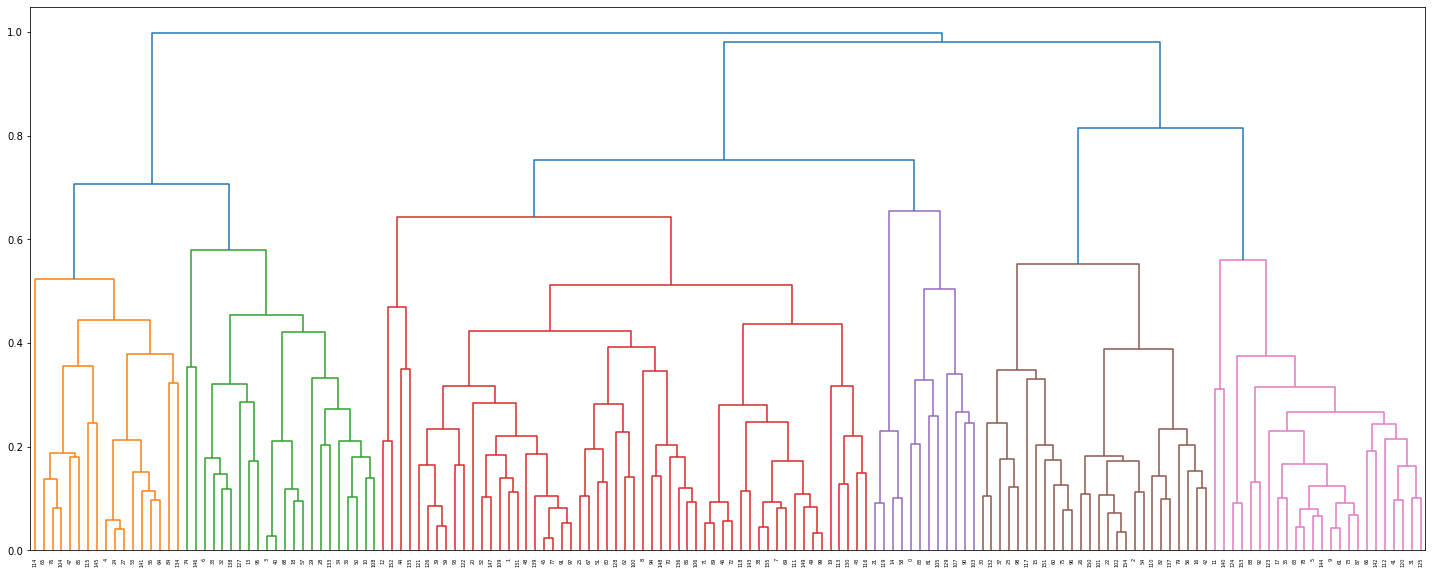

In [44]:
# 시각화
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [45]:
# 적당한 개수의 클러스터로 구분
cluster = pd.DataFrame(fcluster(Z,0.6,criterion='distance'))
cluster.columns=['cluster']

In [46]:
# 결과 DataFrame 구성

# key column 기준 내림차순으로 된 champion_df.name를 cluster 오른쪽에 concat
result = pd.concat([cluster, champion_df.sort_values(by="key", ascending=False)["name"].reset_index(drop=True)], axis=1)
# result == [cluster | name]

In [47]:
# 출력
pd.set_option('display.max_rows', None)
result

,cluster,name
0,6,그웬
1,4,릴리아
2,7,세트
3,2,요네
4,1,파이크
5,8,렐
6,2,아펠리오스
7,4,니코
8,4,사일러스
9,8,오른
